# CE 295 Final Project
# EV Charging Schedule Optimization

## Data Processing for Oakland K Feeder 1103 (Existing General Load Profile)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Read in Collected Data (sources of data are documented in the existing_load_data spreadsheet

Source:

PG&E Integration Capacity Analysis (ICA) Map: https://www.pge.com/b2b/distribution-resource-planning/integration-capacity-map.shtml
Download Spatial Data --> Open GDB in QGIS --> Open Attribute Table for FeederDetail --> Filter for Oakland K Substation Feeder 1103


PG&E Integration Capacity Analysis (ICA) Map: https://www.pge.com/b2b/distribution-resource-planning/integration-capacity-map.shtml
Download Spatial Data --> Open GDB in QGIS --> Open Attribute Table for FeederLoadProfile--> Filter for Oakland K Substation Feeder 1103

In [3]:
# Oakland K Substation Feeder 1103 - # Res vs Non-Rees. Customers, MW existing + queued DG 
oak1103_info = pd.read_excel("existing_load_data.xlsx", "ica_oak_k_feeder1103", header=1)
oak1103_info

,OBJECTID,Substation,FeederID,Feeder_Name,Nominal_Voltage,Load_Profile_Redaction,ResCust,ComCust,IndCust,AgrCust,OthCust,Existing_DG,Queued_DG,Total_DG,Show,VOLTNUM,Shape_Length
0,2655,OAKLAND K,12101103,OAKLAND K 1103,12kV,No,2957,147,16,0,18,3550,1390,4940,1,12,34962.141796


In [4]:
# Oakland K Substation Feeder 1103 - Historical Load Profile Data
# Description from PG&E: 
''' The “Feeder Load Profile” tab shows a summary of the load profile for the feeder. There are two
data series: the first (in orange) represents the expected higher loading conditions and the second
(in blue) shows the lower loading conditions. There are 288 data points for each series that
represent the high and low load values based on a statistical sampling resulting in a 24-hour
period for each month (24 x 12 = 288)'''

oak1103_load = pd.read_excel("existing_load_data.xlsx", "loadprofile_oak_k_feeder1103", header=1)
oak1103_load

,OBJECTID,FeederID,MonthHour,Light,High
0,2081,12101103,01_01,2510,2845
1,3505,12101103,01_00,2471,2791
2,5311,12101103,01_03,2186,2486
3,8379,12101103,01_05,2059,2385
4,10168,12101103,01_06,2101,2476
...,...,...,...,...,...
283,569741,12101103,12_02,2400,2753
284,572789,12101103,12_08,2509,3460
285,575322,12101103,12_13,1770,3326
286,576330,12101103,12_15,1972,3227


Source:
PG&E Distribution Investment Deferral Framework (DIDF) Map: https://www.pge.com/b2b/distribution-resource-planning/grid-needs-assessment-map.html
Download Data --> PGE_2023_GNA_Appendix_E_Public.xlsx --> Filter for Oakland K 1103 (Bank and Feeder Capacity Needs)

In [5]:
# Oakland K Substation Feeder 1103 Capacity Rating
oak1103_capacity = 7.36 

### Process the Historical Load Data into an averaged 24-Hr profile for Low, Mid, and High Scenarios

In [6]:
# Create a copy of oak1103_load to manipulate
oak1103_load_reorg = oak1103_load.copy(deep = True)

# Rename the "Light" column as "Low"
oak1103_load_reorg = oak1103_load_reorg.rename(columns = {"Light": "Low"})

# Add in columns to split out Month and Hour
oak1103_load_reorg.insert(loc = 3, column = "Month", value = [int(oak1103_load_reorg["MonthHour"][row].split("_")[0]) for row in range(0,oak1103_load_reorg.shape[0])])
oak1103_load_reorg.insert(loc = 4, column = "Hour", value = [int(oak1103_load_reorg["MonthHour"][row].split("_")[1]) for row in range(0,oak1103_load_reorg.shape[0])])

# Add in column with "Medium" scenario (average of Low and High Demand columns)
oak1103_load_reorg.insert(loc = 6, column = "Med", value = [np.mean((oak1103_load_reorg["Low"][row],oak1103_load_reorg["High"][row])) for row in range(0,oak1103_load_reorg.shape[0])])

oak1103_load_reorg

,OBJECTID,FeederID,MonthHour,Month,Hour,Low,Med,High
0,2081,12101103,01_01,1,1,2510,2677.5,2845
1,3505,12101103,01_00,1,0,2471,2631.0,2791
2,5311,12101103,01_03,1,3,2186,2336.0,2486
3,8379,12101103,01_05,1,5,2059,2222.0,2385
4,10168,12101103,01_06,1,6,2101,2288.5,2476
...,...,...,...,...,...,...,...,...
283,569741,12101103,12_02,12,2,2400,2576.5,2753
284,572789,12101103,12_08,12,8,2509,2984.5,3460
285,575322,12101103,12_13,12,13,1770,2548.0,3326
286,576330,12101103,12_15,12,15,1972,2599.5,3227


In [7]:
# Create a new df with average hourly load across data points for each of the three scenarios

# Hours in Day
hrs = [hr for hr in range(0,24)]

oak1103_hrly_load = pd.DataFrame({"Hour": hrs, "Low_kW": [np.nan]*len(hrs), "Med_kW": [np.nan]*len(hrs), "High_kW":  [np.nan]*len(hrs)})

# Group the full dataset by hours
grouped_hrly = oak1103_load_reorg.groupby("Hour")

# Iterate over groups by hour to calculate mean value for each scenario
for hr in hrs:
    temp_group = grouped_hrly.get_group(hr)
    oak1103_hrly_load["Low_kW"][hr] = round(np.mean(temp_group["Low"]))
    oak1103_hrly_load["Med_kW"][hr] = round(np.mean(temp_group["Med"]))
    oak1103_hrly_load["High_kW"][hr] = round(np.mean(temp_group["High"]))

oak1103_hrly_load

/var/folders/66/5w9ddbys20s46gg6n2pv35r00000gn/T/ipykernel_18793/3039913769.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oak1103_hrly_load["Low_kW"][hr] = round(np.mean(temp_group["Low"]))
/var/folders/66/5w9ddbys20s46gg6n2pv35r00000gn/T/ipykernel_18793/3039913769.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oak1103_hrly_load["Med_kW"][hr] = round(np.mean(temp_group["Med"]))
/var/folders/66/5w9ddbys20s46gg6n2pv35r00000gn/T/ipykernel_18793/3039913769.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

,Hour,Low_kW,Med_kW,High_kW
0,0,2222.0,2377.0,2531.0
1,1,2238.0,2386.0,2535.0
2,2,2092.0,2230.0,2368.0
3,3,1940.0,2076.0,2212.0
4,4,1844.0,1972.0,2100.0
5,5,1800.0,1927.0,2053.0
6,6,1819.0,1958.0,2097.0
7,7,1908.0,2111.0,2313.0
8,8,2077.0,2380.0,2683.0
9,9,2066.0,2366.0,2665.0


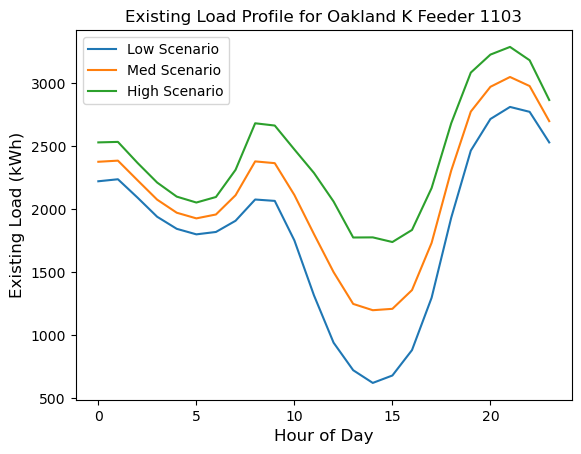

In [8]:
# Visualize Load Profiles

plt.figure()
plt.xlabel("Hour of Day", fontsize = 12)
plt.ylabel("Existing Load (kWh)", fontsize = 12)
plt.title("Existing Load Profile for Oakland K Feeder 1103")

plt.plot(hrs, oak1103_hrly_load["Low_kW"], label = "Low Scenario")
plt.plot(hrs, oak1103_hrly_load["Med_kW"], label = "Med Scenario")
plt.plot(hrs, oak1103_hrly_load["High_kW"], label = "High Scenario")

#plt.plot(hrs, [oak1103_capacity * 1000] * 24, label = "Capacity Constraint")

plt.legend()

plt.show()

### Export Processed Data back to CSV

In [9]:
oak1103_hrly_load.to_csv("OAK1103_Hrly_Load.csv")